In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.llamma import LLAMMA
from src.controller import Controller
from src.oracle import Oracle
from src.mpolicy import MonetaryPolicy
from src.liquidator import Liquidator
import pandas as pd
import numpy as np
from datetime import datetime
from src.utils import _plot_borrowers, gen_gbm

In [3]:
WINDOW = 600 # 10 minutes
BASE_PRICE = 1800
A = 100
FEE = 0.006
ADMIN_FEE = 1
LOAN_DISCOUNT = 0.09
LIQUIDATION_DISCOUNT = 0.06

N_BORROWERS = 100
VALUE = 60_000_000 # USD value of collateral
COINS = 60_000_000 / BASE_PRICE # Number of collateral coins
DEBT = 44_000_000 # crvUSD debt

TOLERANCE = 0 # Min profit for liquidator to act

START = int(datetime.now().timestamp())

oracle = Oracle(WINDOW)
oracle.update(START, BASE_PRICE) # set initial price
llamma = LLAMMA(A, BASE_PRICE, oracle, FEE, admin_fee=ADMIN_FEE)
mpolicy = MonetaryPolicy()
controller = Controller(llamma, mpolicy, LOAN_DISCOUNT, LIQUIDATION_DISCOUNT) 
liquidator = Liquidator(TOLERANCE)

Total collateral: 60 Mns USD
Total debt: 38 Mns USD


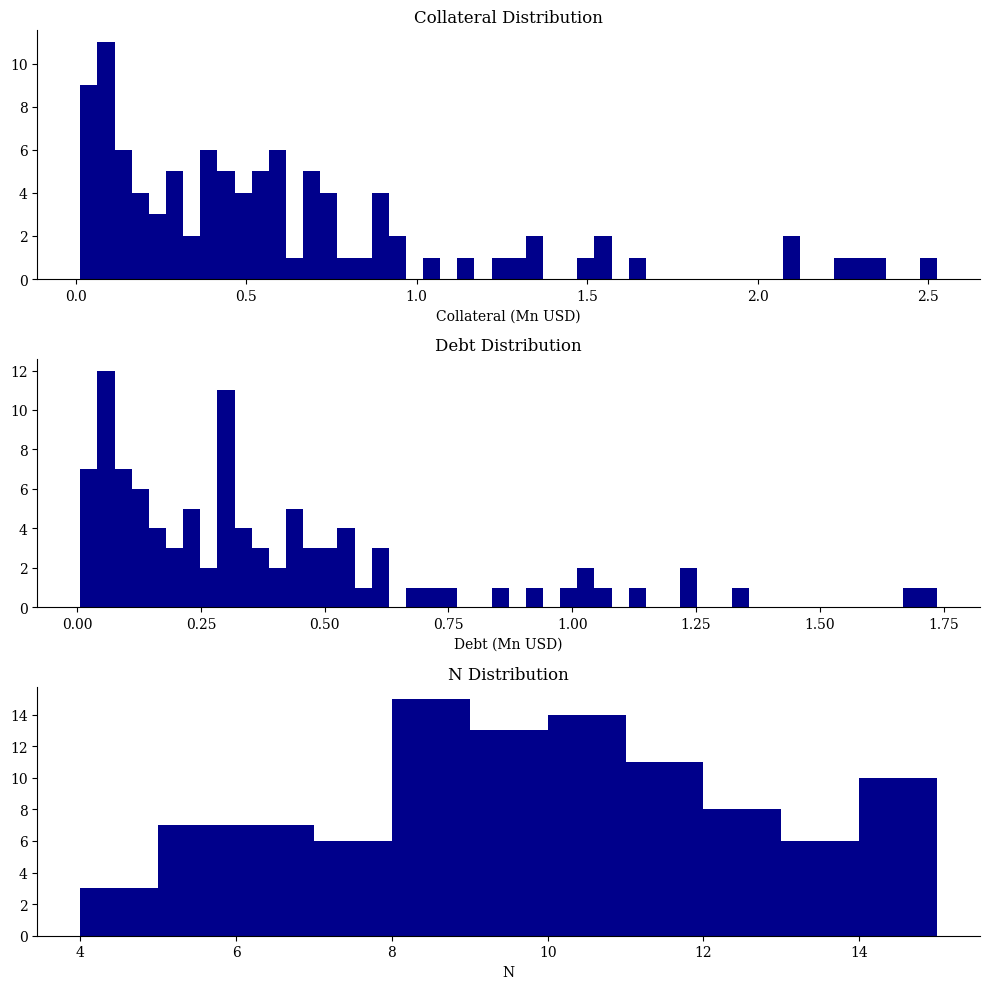

In [4]:
borrowers = controller.gen_borrowers(N_BORROWERS, COINS, v=True)
_plot_borrowers(borrowers, BASE_PRICE)

In [5]:
# Check that this generate func will generally give us ~
debts = []
for _ in range(1000):
    bs = controller.gen_borrowers(N_BORROWERS, COINS)
    debts.append(bs[:,1].sum())
print(f"Mean debt: {round(np.mean(debts) / 1e6)} Mns USD")
print(f"Desired debt: {DEBT / 1e6} Mns USD")

Mean debt: 39 Mns USD
Desired debt: 44.0 Mns USD


In [6]:
for i, b in enumerate(borrowers):
    # Deposit!
    controller.create_loan(i, *b)

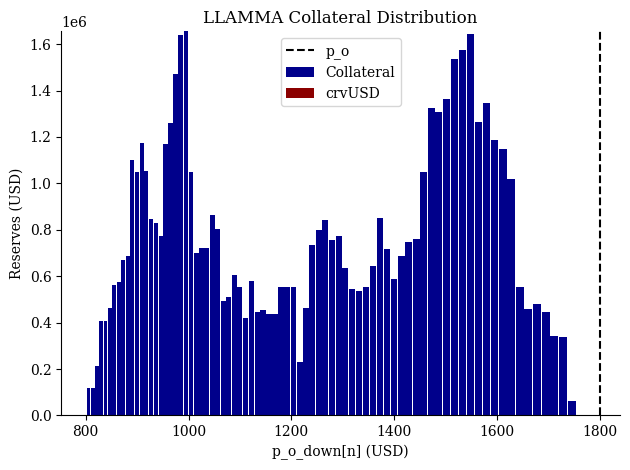

In [7]:
llamma.plot_reserves()

In [8]:
# NOTE run this to see that oracle updates affect llamma
# oracle.update(START + 60*60, BASE_PRICE * 0.9)
# llamma.plot_reserves()

In [9]:
# Now let's create some dummy prices and assume that liquidators
# will liquidate when profitable.

WINDOW = 3600 # 1 hrs # NOTE this is way longer than the actual contract
PERIOD = 86400 # 1 day

times = [int(START + dt*60) for dt in range(0, PERIOD//60)]

df = pd.DataFrame(columns=['timestamp', 'spot', 'oracle', 'liquidation_pnl'])
df['timestamp'] = times
df.index = pd.to_datetime(df['timestamp'], unit='s')
df['spot'] = gen_gbm(S0=BASE_PRICE,mu=0.05, sigma=0.2, dt=1/1440,T=1)
df.head()

,timestamp,spot,oracle,liquidation_pnl
timestamp,,,,
2023-10-14 21:25:05,1697318705,1814.189102,NaN,NaN
2023-10-14 21:26:05,1697318765,1818.434856,NaN,NaN
2023-10-14 21:27:05,1697318825,1818.836415,NaN,NaN
2023-10-14 21:28:05,1697318885,1806.673434,NaN,NaN
2023-10-14 21:29:05,1697318945,1812.481934,NaN,NaN


In [10]:
spot = BASE_PRICE
n = llamma.active_band
if spot < llamma.p():
    y_new = (llamma.inv(n) / spot) ** 0.5 - llamma.g(n)
    if y_new < 0:
        

1818.1818181818182

In [12]:
spot = BASE_PRICE
n = llamma.active_band
y_new = (llamma.inv(n) / spot) ** 0.5 - llamma.g(n)
y_new

0.0

In [16]:
llamma.y0(n)

0.0

In [ ]:
# TODO arbitrage doesn't work because invariant is zero when x = 0
# actually it's probs because there's x=y=0 rn, so just need to take us to the right band

In [13]:
# Init external market liquidity for slippage calc
ext_stable_liquidity = 2e8 # NOTE why 2M?
ext_collat_liquidity = ext_stable_liquidity / BASE_PRICE
ext_swap_fee = 0.005

# Run simulation
for i, row in df.iterrows():
    
    # Update oracle
    ema_price = oracle.update(row['timestamp'], row['spot'])
    df.loc[i, 'oracle'] = ema_price

    # Update external liquidity
    ext_collat_liquidity = ext_stable_liquidity / row['spot']

    # Check for liquidations
    liquidator.perform_liquidations(controller, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    df.loc[i, 'liquidation_pnl'] = liquidator.pnl
    
    # Check for arbitrage
    

No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''